# Problem Statement
Example 4.2 - Reinforcement Learning: An Introduction, Sutton and Barto, Second Edition - Dynamic Programming

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited 10 USD by the national company. If he is out of cars at that location, then the business is lost. Cars become available for rent the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of 2 USD per car moved.

We assume that the number of cars requested and returned at each location is a Poisson random variable. The probability that
the number is n is (λ^n)*(e^(−λ))/n!, where λ is the expected number.

Suppose λ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns.
To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate γ to be 0.9 and formulate this as a continuing finite Markov Decision Process, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net number of cars moved between the two locations overnight.

How many cars should Jack move overnight to maximize his total expected reward, i.e., what should be his policy, given a state. If Jack knows this strategy, how can he compare which situations are better than others (value)?

This problem is solved here using dynamic programming, which assumes complete knowledge of the environment and state probablities.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson
from typing import List, Tuple

In [2]:
# maximum number of cars in each location
MAX_CARS = 20

# maximum number of cars to move during a night
MAX_CAR_MOVES = 5

# expected value for rental requests in first location
EXPECTED_RENTAL_FIRST_LOC = 3

# expected value for rental requests in second location
EXPECTED_RENTAL_SECOND_LOC = 4

# expected value for number of cars returned in the first location
EXPECTED_RETURNS_FIRST_LOC = 3

# expected value for number of cars returned in the second location
EXPECTED_RETURNS_SECOND_LOC = 2

DISCOUNT_RATE = 0.9

# credit earned by renting a car
RENTAL_CREDIT = 10

# cost of moving a car
CAR_MOVE_COST = 2

# possible actions, the number of cars that he can move from the first to the second location or vice-versa
actions = np.arange(- MAX_CAR_MOVES, MAX_CAR_MOVES + 1)

# upper-bound for n to truncate the poisson distribution probablity to 0
POISSON_UPPER_BOUND = 10

# caching of poisson distribution probabilities
poisson_cache = dict()

In [3]:
def poission_distribution(n: int, lam: int) -> float:
    """
    Poisson distribution for expected value lam (lambda)
    """
    global poisson_cache
    key = n * 10 + lam # simple hash for quick caching 
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

In [4]:
def expected_return(state: Tuple[int, int], action: int, state_value: List) -> float:
    """
    @state: [number of cars in first location, number of cars in second location]
    @action: positive if moving cars from first location to the second location,
             negative if moving cars from second location to the first location
    @stateValue: state value matrix    
    """
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= CAR_MOVE_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability of current combination of rental requests
            prob_rental = poission_distribution(rental_request_first_loc, EXPECTED_RENTAL_FIRST_LOC) * \
                          poission_distribution(rental_request_second_loc, EXPECTED_RENTAL_SECOND_LOC)
            
            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual number of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            
            # update number of cars after rentals
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            # go through all possible return requests
            for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                    # probability of current combination of return requests
                    prob_return = poission_distribution(returned_cars_first_loc, EXPECTED_RETURNS_FIRST_LOC) * \
                                  poission_distribution(returned_cars_second_loc, EXPECTED_RETURNS_SECOND_LOC)
                    
                    # find the future state (number of cars after processing the returns)
                    num_of_cars_first_loc_future = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                    num_of_cars_second_loc_future = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                    
                    # calculate the combined rental and returns probabality
                    prob = prob_return * prob_rental
                    
                    # update the state value using Bellman equation
                    returns += prob * (reward + DISCOUNT_RATE *
                                        state_value[num_of_cars_first_loc_future, num_of_cars_second_loc_future])
    return returns

In [5]:
value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy = np.zeros(value.shape, dtype=int)
iterations = 0

while True:
    # policy evaluation
    while True:
        old_value = value.copy()
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                new_state_value = expected_return([i, j], policy[i, j], value)
                value[i, j] = new_state_value
        max_value_change = abs(old_value - value).max()
        print(f'max value change = {max_value_change}')
        if max_value_change < 1e-3:
            break

    # policy improvement
    policy_converged = True
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i, j]
            action_returns = []
            for action in actions:
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value))
                else:
                    action_returns.append(-np.inf)
            new_action = actions[np.argmax(action_returns)]
            policy[i, j] = new_action
            if policy_converged and old_action != new_action:
                policy_converged = False
    print(f'policy converged = {policy_converged}')

    if policy_converged:
        break

    iterations += 1

max value change = 186.93319187551955
max value change = 127.82166017557387
max value change = 84.96361705168559
max value change = 63.6356063810743
max value change = 49.75082461662316
max value change = 38.108878052136504
max value change = 29.343617957687627
max value change = 22.945149327786908
max value change = 18.880768982072027
max value change = 15.601811185735983
max value change = 12.857391621743773
max value change = 10.569213509215217
max value change = 8.667883923962904
max value change = 7.093135923083082
max value change = 5.792969996138595
max value change = 4.722689644386037
max value change = 3.8440491720335785
max value change = 3.124505168842461
max value change = 2.5365344881785745
max value change = 2.056999604618909
max value change = 1.6665585461781234
max value change = 1.3491234165543347
max value change = 1.0913719596181295
max value change = 0.8823143808923533
max value change = 0.7129149427041739
max value change = 0.5757656448822104
max value change = 0.4

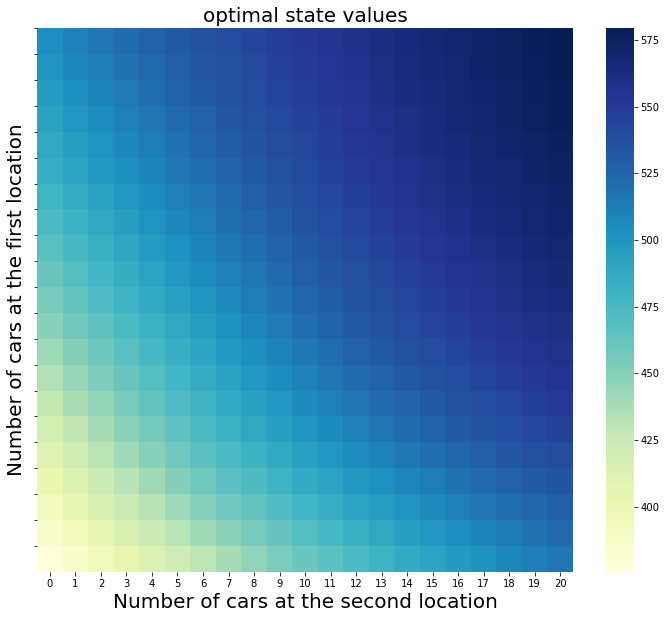

In [16]:
fig, ax = plt.subplots(figsize=(12,10))
fig = sns.heatmap(np.flipud(value), cmap="YlGnBu")
fig.set_ylabel('Number of cars at the first location', fontsize=20)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('Number of cars at the second location', fontsize=20)
fig.set_title('optimal state values', fontsize=20)
plt.show()
plt.close()

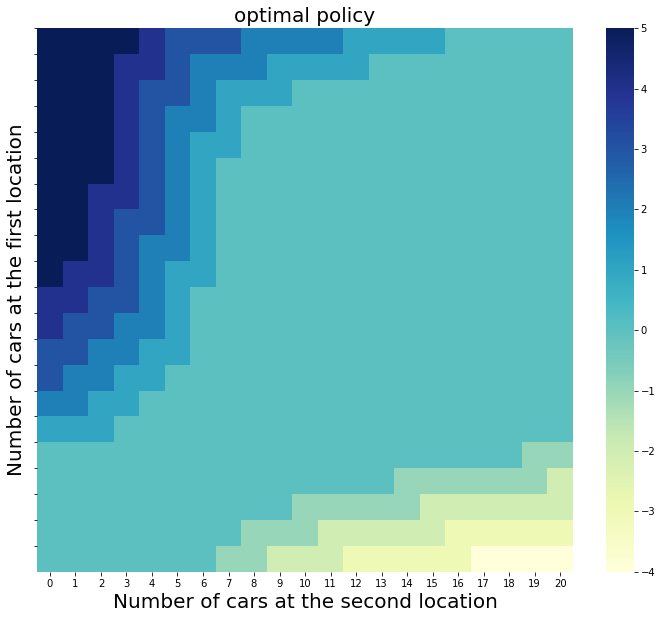

In [15]:
fig, ax = plt.subplots(figsize=(12,10))
fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu")
fig.set_ylabel('Number of cars at the first location', fontsize=20)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('Number of cars at the second location', fontsize=20)
fig.set_title('optimal policy', fontsize=20)
plt.show()
plt.close()